## Predicting NBA Player Days Out From Injury



In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 4)

Lets Import our cleaned data set

In [69]:
df = pd.read_csv("../data/merged_data.csv")
df.head()

,PLAYER_NAME,SEASON,AGE,GAMES_PLAYED,GAMES_STARTED,MINUTES_PLAYED,POINTS_SCORED,HEIGHT,WEIGHT,POSITION,DAYS_OUT_NEXT
0,A.J. Guyton,2000-01,23.0,33,8.0,630,198,74,185.0,Guard,11.0
1,A.J. Guyton,2001-02,24.0,45,6.0,604,244,74,185.0,Guard,14.0
2,A.J. Guyton,2001-02,24.0,45,6.0,604,244,74,185.0,Guard,11.0
3,A.J. Guyton,2001-02,24.0,45,6.0,604,244,74,185.0,Guard,10.0
4,Aaron Brooks,2007-08,23.0,51,0.0,608,264,72,161.0,Guard,10.0


First we will drop the columns that we do not need anymore

In [70]:
df = df.drop(columns=["SEASON"])

In [71]:
df.describe()

,AGE,GAMES_PLAYED,GAMES_STARTED,MINUTES_PLAYED,POINTS_SCORED,HEIGHT,WEIGHT,DAYS_OUT_NEXT
count,17133.000000,17133.000000,17133.000000,17133.000000,17133.000000,17133.000000,17133.000000,17133.000000
mean,26.914142,39.981673,19.083640,895.315998,393.982665,78.962528,222.490224,13.289733
std,4.303433,22.953775,24.613509,776.356714,433.706595,3.537102,27.477031,22.004963
min,18.000000,1.000000,0.000000,0.000000,0.000000,65.000000,133.000000,0.000000
25%,24.000000,20.000000,0.000000,206.000000,63.000000,77.000000,201.000000,2.000000
50%,26.000000,40.000000,5.000000,674.000000,231.000000,79.000000,220.000000,6.000000
75%,30.000000,61.000000,34.000000,1481.000000,591.000000,82.000000,240.000000,14.000000
max,42.000000,82.000000,82.000000,3406.000000,2818.000000,91.000000,330.000000,318.000000


### Numerical Features

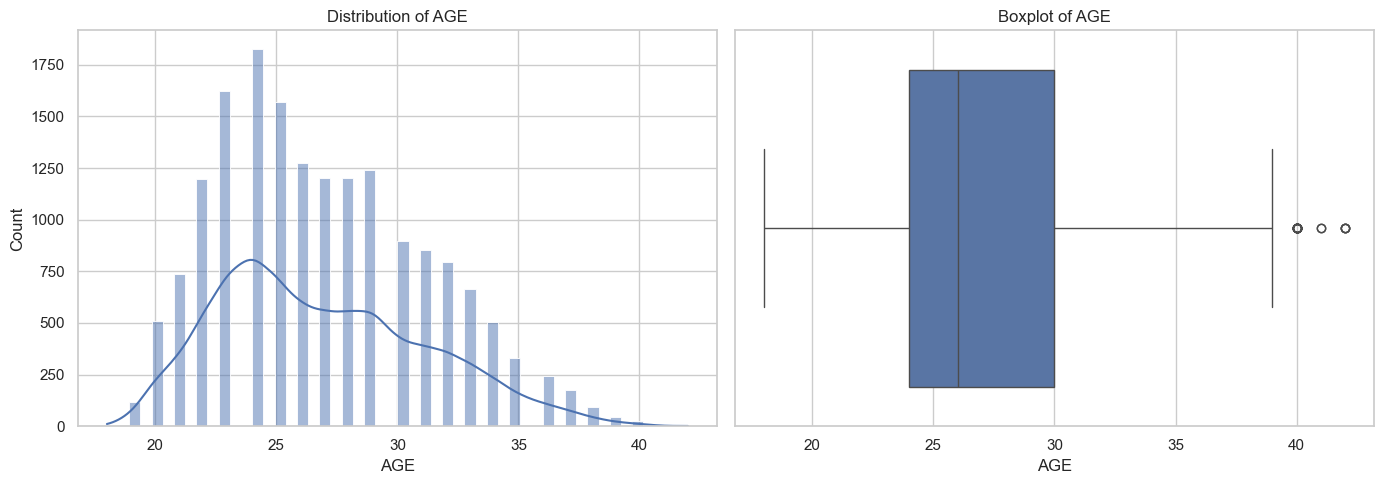

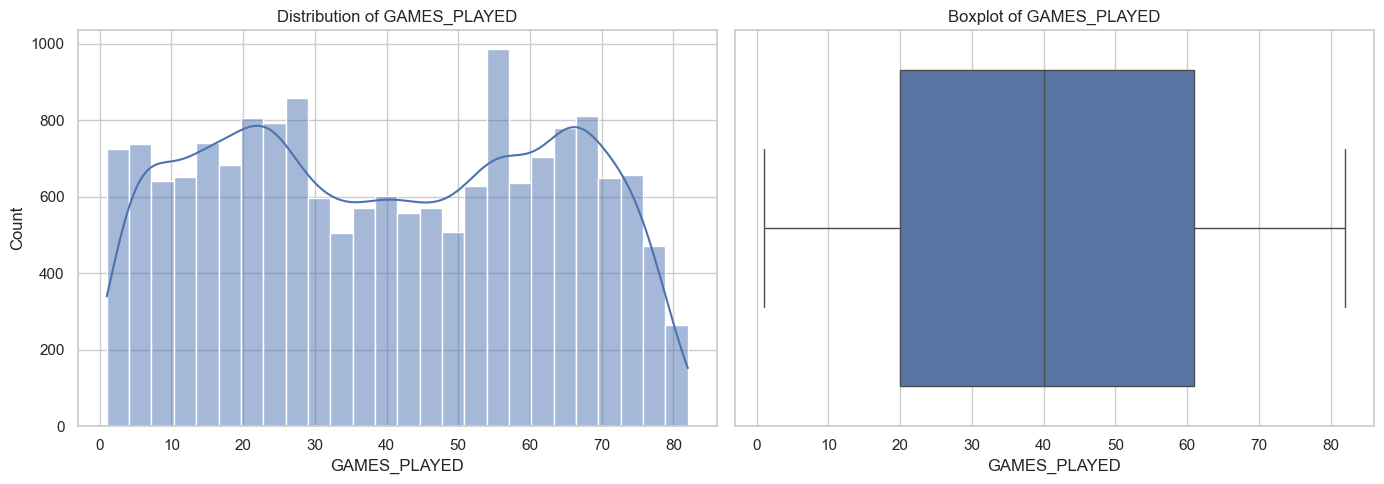

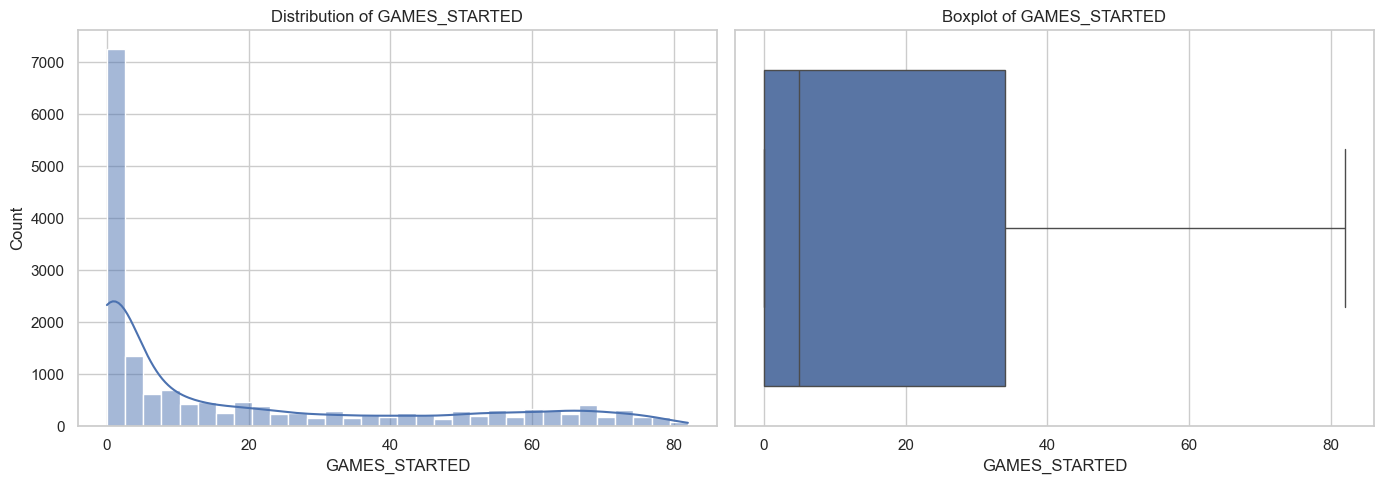

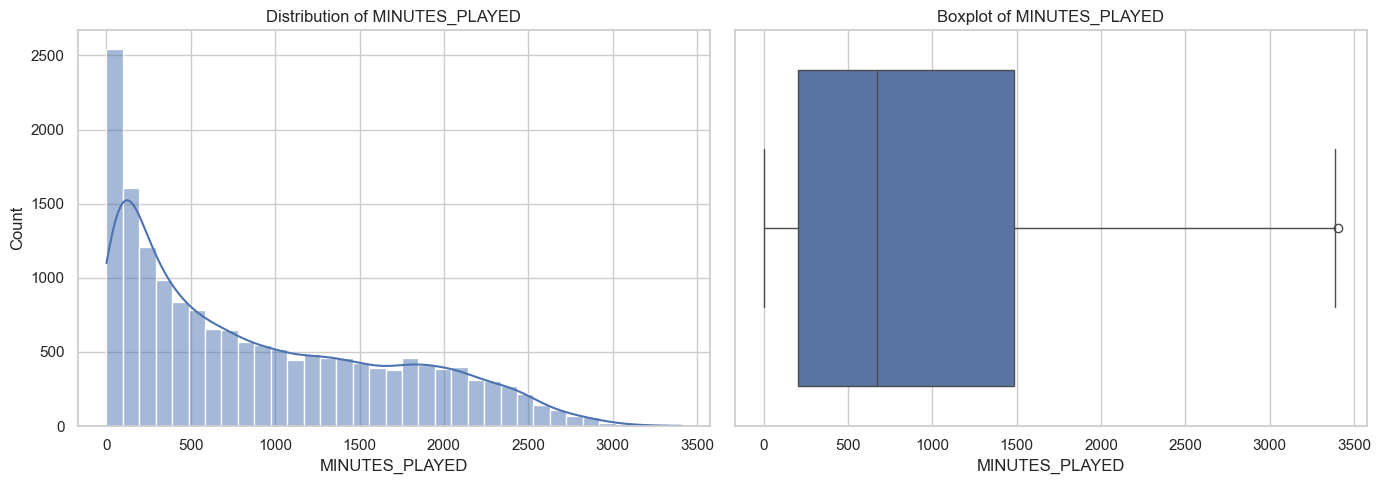

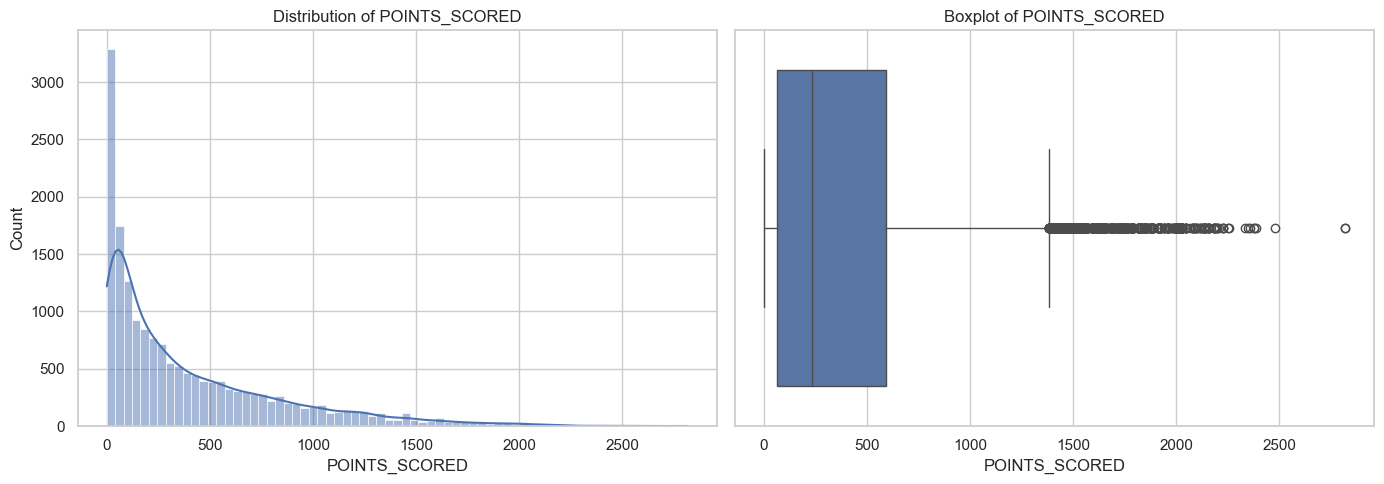

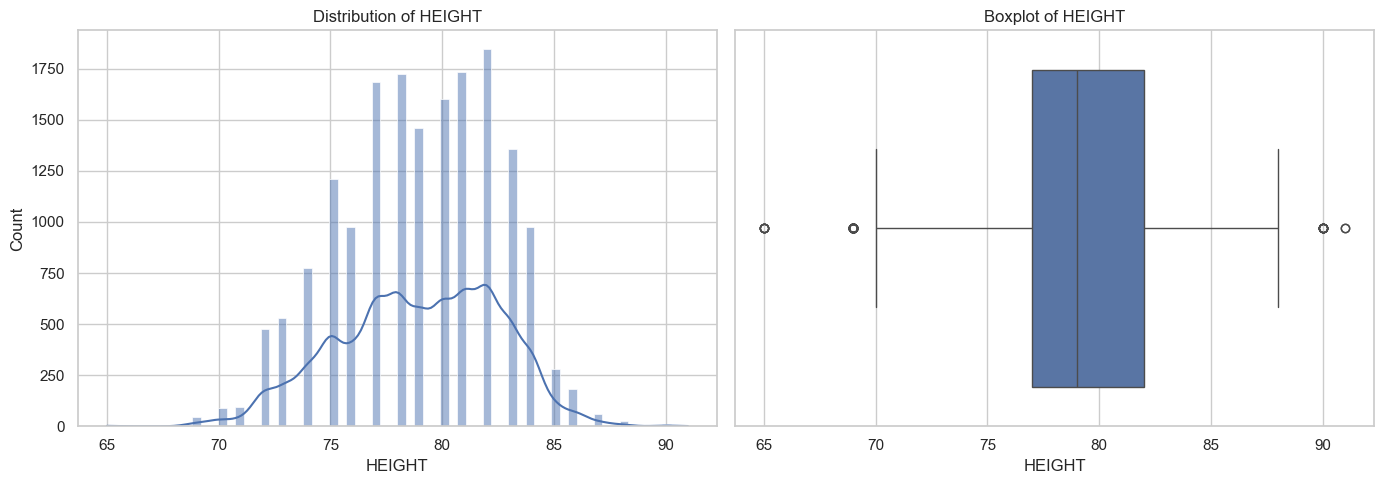

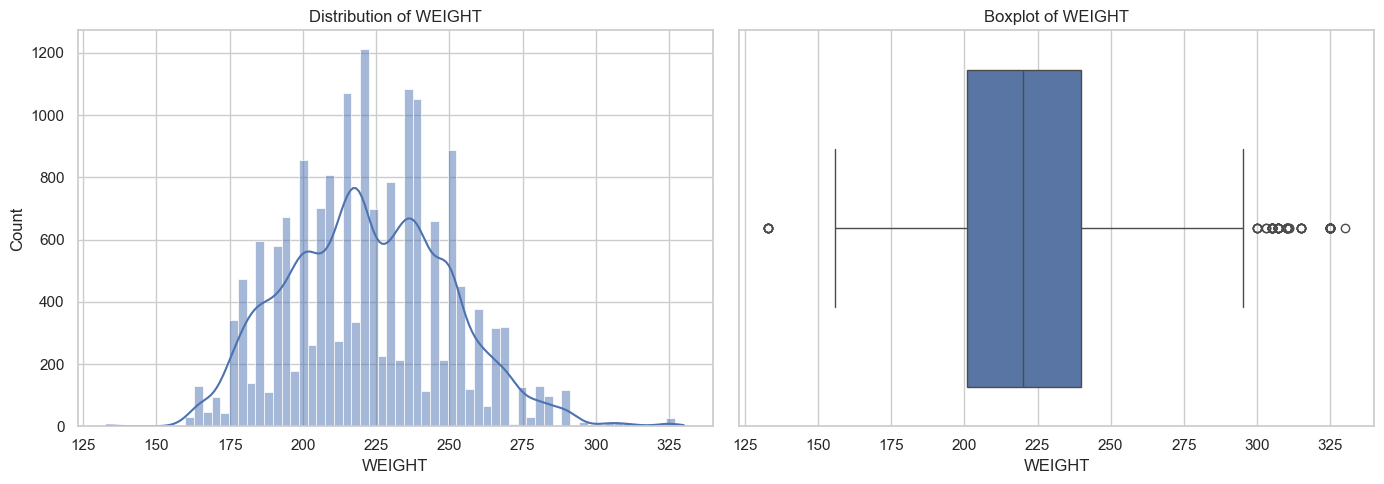

In [72]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop("DAYS_OUT_NEXT")

for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()


Many of our numerical features are heavily skewed, meaning they contain long tails and uneven distributions. While this can be a problem for linear or distance-based models, Random Forests are unaffected because they split data using thresholds rather than relying on the shape of the distribution. This makes Random Forests naturally robust to skewness and outliers. For this reason, a Random Forest is a strong choice for predicting DAYS_OUT without requiring additional transformations.

### Categorical Feature

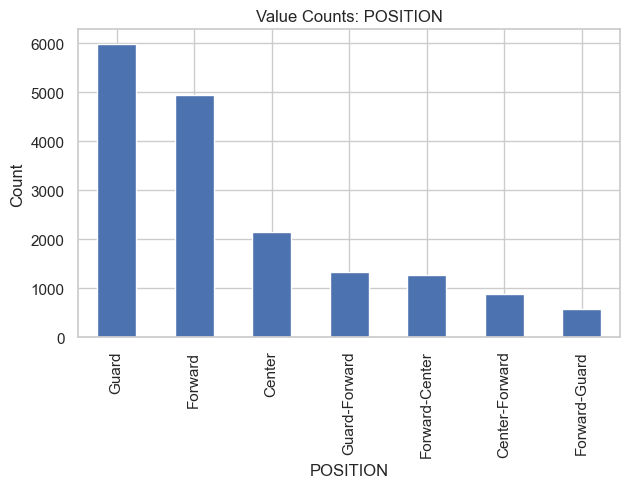

In [73]:
cat_cols = ['POSITION']

for col in cat_cols:
    plt.figure()
    df[col].value_counts().plot(kind="bar")
    plt.title(f"Value Counts: {col}")
    plt.ylabel("Count")
    plt.show()


### Target Variable

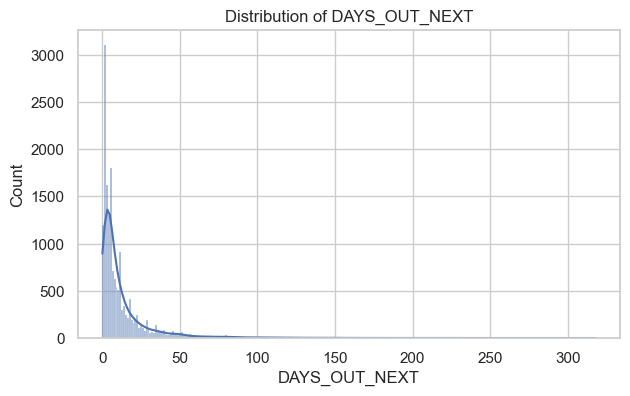

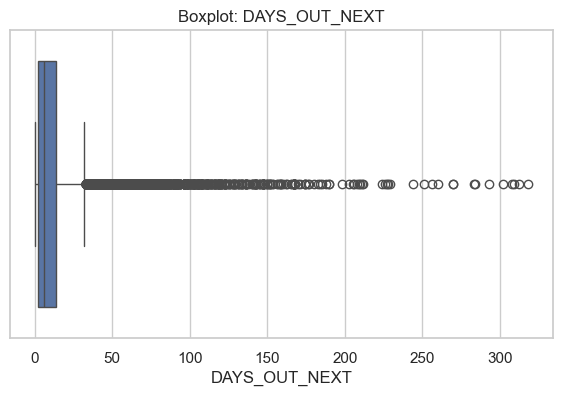

In [74]:
plt.figure()
sns.histplot(df["DAYS_OUT_NEXT"], kde=True)
plt.title("Distribution of DAYS_OUT_NEXT")
plt.show()

plt.figure()
sns.boxplot(x=df["DAYS_OUT_NEXT"])
plt.title("Boxplot: DAYS_OUT_NEXT")
plt.show()

#### Modeling


In [75]:
def model():

    X = df.drop(columns=["DAYS_OUT_NEXT","PLAYER_NAME"])
    y = df["DAYS_OUT_NEXT"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)

    X_train, X_test = X_train.align(X_test, join='left', axis=1)
    X_test = X_test.fillna(0)


    
    model = RandomForestRegressor(n_estimators=300, random_state=55)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    print("MAE:", mean_absolute_error(y_test, preds))
    print("R²:", r2_score(y_test, preds))

    importances = pd.Series(model.feature_importances_, index=X_train.columns)
    top = importances.sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=top.values, y=top.index)
    plt.title("Most Important Features")
    plt.show()


MAE: 12.7565748531718
R²: -0.04213669727425584


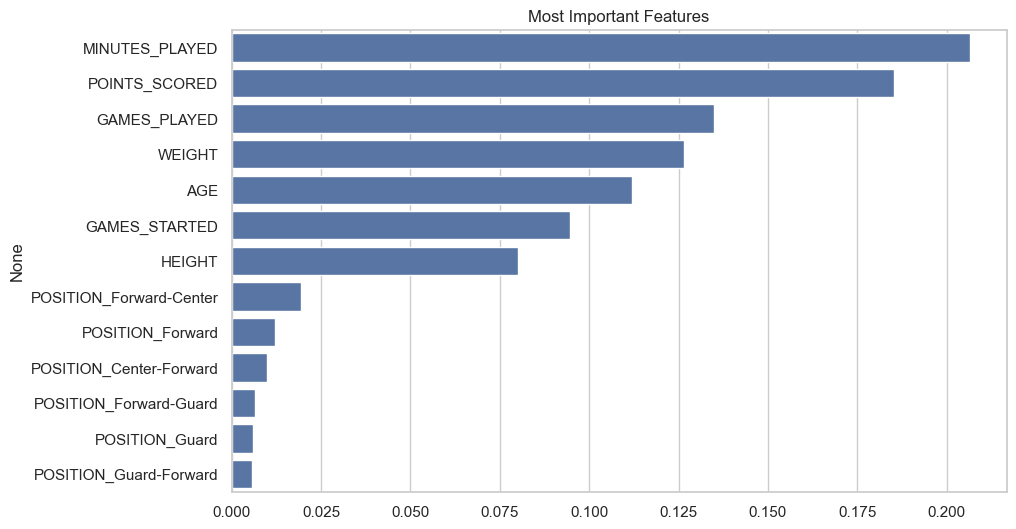

In [76]:
model()

Our R² is currently negative, meaning our model is performing worse than simply predicting the mean. This is expected in injury prediction because DAYS_OUT_NEXT is highly skewed and influenced by many unpredictable factors. However, we can try to improve the model by engineering new features that capture meaningful patterns as well as transforming our target to prevent noise from outliers.

In [ ]:
# Previous season injury days
df["DAYS_OUT_PREV"] = df.groupby("PLAYER_NAME")["DAYS_OUT_NEXT"].shift(1)

# Drop rows where previous season data doesn't exist
df = df.dropna(subset=["DAYS_OUT_PREV"])

df["BMI"] = df["WEIGHT"]/(df["HEIGHT"]**2)*703

df["MIN_PER_GAME"] =df["MINUTES_PLAYED"]/df["GAMES_PLAYED"]

df["START_RATIO"] =df["GAMES_STARTED"]/df["GAMES_PLAYED"]

df["PTS_PER_MIN"] =df["POINTS_SCORED"]/df["MINUTES_PLAYED"]

df["TOTAL_MIN_PREV"] =df.groupby("PLAYER_NAME")["MINUTES_PLAYED"].shift(1)

df["AVG_DAYS_OUT_PREV_2Y"] =df.groupby("PLAYER_NAME")["DAYS_OUT_NEXT"].shift(1).rolling(2).mean().reset_index(level=0, drop=True)

df["WORKLOAD_CHANGE"] = df["MINUTES_PLAYED"] - df.groupby("PLAYER_NAME")["MINUTES_PLAYED"].shift(1)

df = df.dropna(subset=["TOTAL_MIN_PREV", "AVG_DAYS_OUT_PREV_2Y", "WORKLOAD_CHANGE"])



In [78]:
def model():

    X = df.drop(columns=["DAYS_OUT_NEXT","PLAYER_NAME"])
    y = df["DAYS_OUT_NEXT"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)

    X_train, X_test = X_train.align(X_test, join='left', axis=1)
    X_test = X_test.fillna(0)

    # Log-transform the target variable
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    
    model = RandomForestRegressor(n_estimators=300, random_state=55)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    print("MAE:", mean_absolute_error(y_test, preds))
    print("R²:", r2_score(y_test, preds))

    importances = pd.Series(model.feature_importances_, index=X_train.columns)
    top = importances.sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=top.values, y=top.index)
    plt.title("Most Important Features")
    plt.show()


MAE: 0.7456777575265869
R²: 0.05414533005697475


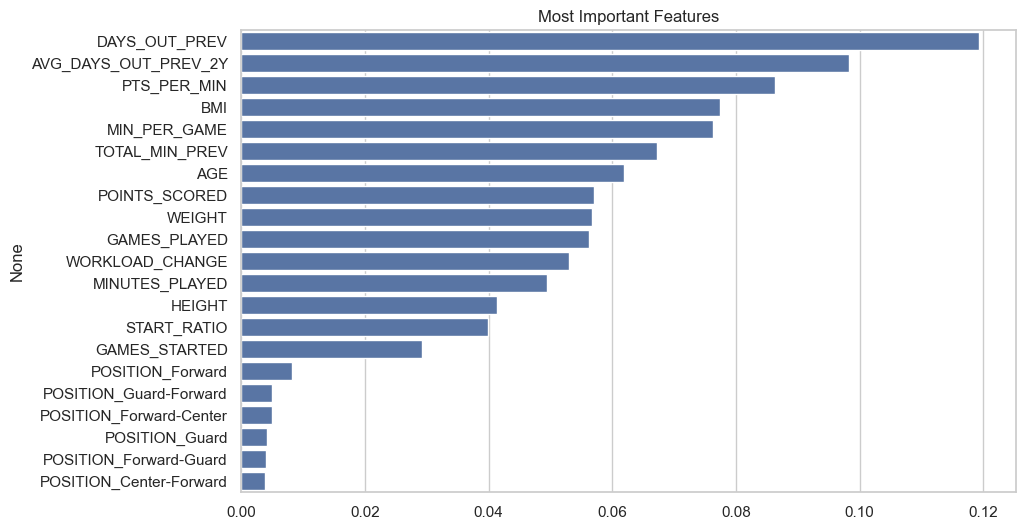

In [79]:
model()

Thats better, now lets try hyperparamter tuning to improve our model even more. We will try different combinations of hyperparameters to evaluate which is best.

In [80]:
def model():
    X = df.drop(columns=["DAYS_OUT_NEXT","PLAYER_NAME"])
    y = df["DAYS_OUT_NEXT"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)
    X_train, X_test = X_train.align(X_test, join='left', axis=1)
    X_test = X_test.fillna(0)

    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    n_estimators_list = [100, 200, 300]
    max_depth_list = [None, 5, 10]
    min_samples_split_list = [2, 5]
    min_samples_leaf_list = [1, 2]

    best_mae = float('inf')
    best_r2 = float('-inf')
    best_params = None
    best_model = None

    # Loop through all combinations
    for n in n_estimators_list:
        for depth in max_depth_list:
            for split in min_samples_split_list:
                for leaf in min_samples_leaf_list:
                    rf = RandomForestRegressor(
                        n_estimators=n,
                        max_depth=depth,
                        min_samples_split=split,
                        min_samples_leaf=leaf,
                        random_state=55
                    )
                    rf.fit(X_train, y_train)
                    preds = rf.predict(X_test)
                    mae = mean_absolute_error(y_test, preds)
                    r2 = r2_score(y_test, preds)

                    # Keep track of best MAE
                    if mae < best_mae:
                        best_mae = mae
                        best_r2 = r2
                        best_params = {'n_estimators': n, 'max_depth': depth,
                                       'min_samples_split': split, 'min_samples_leaf': leaf}
                        best_model = rf

    print("Best Hyperparameters:", best_params)
    print("Best MAE:", best_mae)
    print("Best R²:", best_r2)

    # Feature importance of best model
    importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    top = importances.sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=top.values, y=top.index)
    plt.title("Most Important Features")
    plt.show()


Best Hyperparameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
Best MAE: 0.7391856252868586
Best R²: 0.07761778845737877


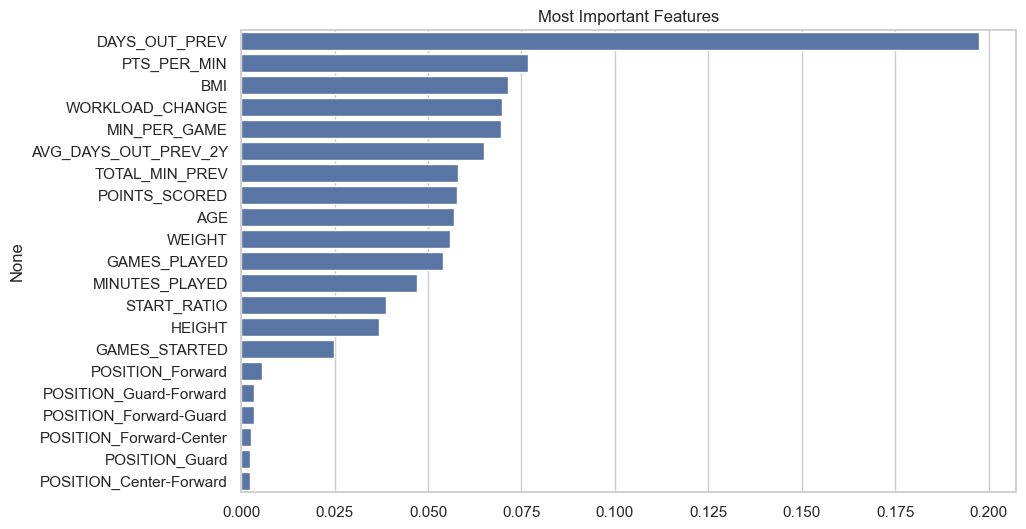

In [81]:
model()

### Results


After manual hyperparameter tuning, the best Random Forest parameters were:

- n_estimators: 300
- max_depth: 10
- min_samples_split: 5
- min_samples_leaf: 2


The model achieved a Mean Absolute Error of 0.74, and an R² of 0.078, meaning it explains roughly 7–8% of the variance in DAYS_OUT_NEXT. This relatively low R² is expected because injury days are highly skewed and influenced by random events that are difficult to predict. Despite the low R², the model can still capture general trends and identify the most important features contributing to injury risk.\
\
Visualization of residuals and predictions helps assess where the model performs well and poorly.

In [ ]:
def model():
    X = df.drop(columns=["DAYS_OUT_NEXT","PLAYER_NAME"])
    y = df["DAYS_OUT_NEXT"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)
    X_train, X_test = X_train.align(X_test, join='left', axis=1)
    X_test = X_test.fillna(0)

    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)


    best_model = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=55
    )

    best_model.fit(X_train, y_train)
    preds_log = best_model.predict(X_test)
    preds = np.expm1(preds_log) 

    y_test_original = np.expm1(y_test)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test_original, preds, alpha=0.6)
    plt.plot([0, max(y_test_original)],[0, max(y_test_original)], color='red', linestyle='--')
    plt.xlabel("Actual DAYS_OUT_NEXT")
    plt.ylabel("Predicted DAYS_OUT_NEXT")
    plt.title("Predicted vs Actual")
    plt.show()

    residuals = y_test_original - preds

    plt.figure(figsize=(8,4))
    plt.scatter(y_test_original, residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Actual DAYS_OUT_NEXT")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Actual DAYS_OUT_NEXT")
    plt.show()



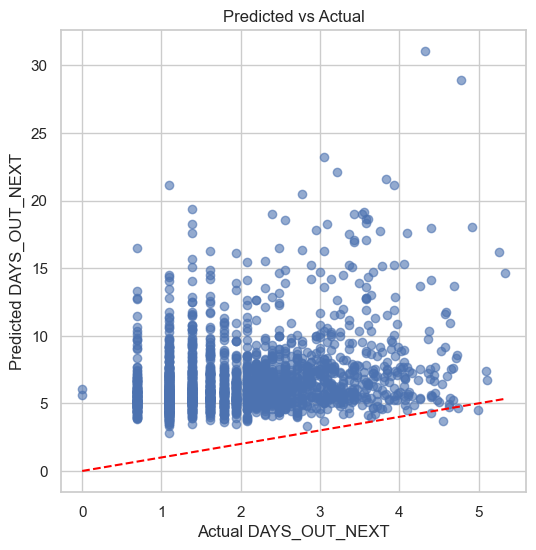

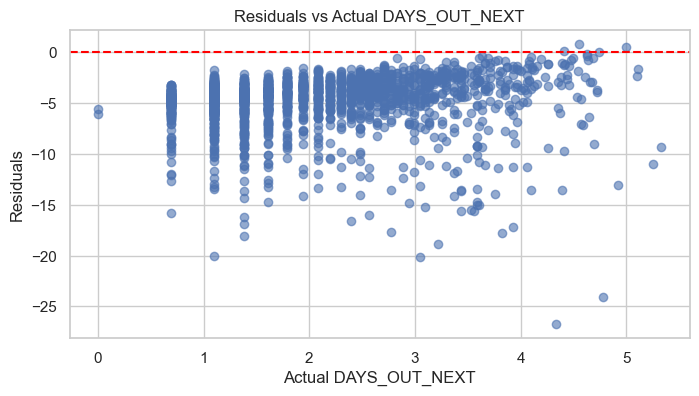

In [83]:
model()

The Predicted vs Actual plot shows that the model captures general trends for players with low days out, but tends to underpredict rare longer injuries. Most predictions are clustered at the lower end due to the skewed distribution of DAYS_OUT_NEXT.
The residuals plot confirms this, residuals are small for the majority of players but increase for higher actual days out, indicating the model has difficulty predicting extreme injuries. Overall, the model is more reliable for predicting typical short-term injuries and highlights the challenge of predicting rare, high-impact injuries.